In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
import sys, gc, warnings, random, math, time, datetime 
from tqdm import tqdm
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from scipy.stats.stats import pearsonr
import hashlib
import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 500
pd.options.display.max_columns = None

import os
print(os.listdir("../input/features/"))

['train_y.pkl', 'train_uid_features.pkl', 'train_features.pkl', 'useful_features.npy', 'test_features.pkl', 'test_uid_features.pkl', 'train_basic_features.pkl', 'rm_features.npy', 'test.pkl', 'test_basic_features.pkl', 'train.pkl']


In [2]:
train = pd.read_pickle('../input/mini-model-data/train_df_w.pkl')
test = pd.read_pickle('../input/mini-model-data/test_df_w.pkl')
train= train.reset_index()
test= test.reset_index()

print(train.shape)
print(test.shape)

(439670, 394)
(360987, 394)


In [3]:
block_users_id = np.load('../input/block_users_id.npy')
block_users_id = []

block_users_id = list(set(block_users_id))

print("black user # ", len(block_users_id))

black user #  0


In [4]:
train['ProductCD'].unique()

array(['W'], dtype=object)

In [5]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [6]:
# fe with DT
def fe_dt(train_df, test_df, rm_features):

    print('==> processing DT...')
    
    for df in [train_df, test_df]:
        df['DT'] = df['TransactionDT'].apply(
            lambda x: (START_DATE + datetime.timedelta(seconds=x)))
        df['DT_month'] = (df['DT'].dt.year - 2017) * 12 + df['DT'].dt.month
        df['DT_week_year'] = (df['DT'].dt.year - 2017) * 52 + df['DT'].dt.weekofyear
        df['DT_day_year'] = (df['DT'].dt.year - 2017) * 365 + df['DT'].dt.dayofyear

        df['DT_hour'] = df['DT'].dt.hour
        df['DT_day_week'] = df['DT'].dt.dayofweek
        df['DT_day'] = df['DT'].dt.day

    rm_features = rm_features

    return train_df, test_df, rm_features
rm_features = []
train, test, rm_features = fe_dt(train, test, rm_features)

==> processing DT...


In [7]:
# fe with W: D 1,2,3,4,5,10,11,15
def fe_d(train_df, test_df, rm_features):
    
    print('==> processing D...')
    
#     d_cols = ['D' + str(i) for i in range(1,16)]
    d_cols = ['D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11','D15']

    for df in [train_df, test_df]:        
        for col in d_cols:
            df[col + '_corrected'] = df[col] - df['DT_day_year'] + train_df['DT_day_year'].min()
            df[col + '_corrected'] = df[col + '_corrected'].apply(lambda y: max(0,y))
            df[col + '_corrected'] = df[col + '_corrected'].apply(lambda y: round(y/10))
            
            
    rm_features = rm_features
    return train_df, test_df, rm_features
# rm_features = []
train, test, rm_features = fe_d(train, test, rm_features)

==> processing D...


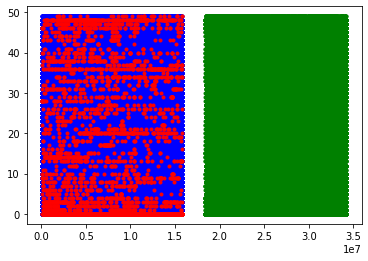

In [8]:
col = 'D15_corrected'
plt.plot(train.set_index('TransactionDT')[train.set_index('TransactionDT').isFraud == 0][col],  '.b')
plt.plot(train.set_index('TransactionDT')[train.set_index('TransactionDT').isFraud == 1][col],  '.r')

plt.plot(test.set_index('TransactionDT')[col],  '.g')


In [9]:
for df in [train, test]:
    df['card1'] = df['card1'].fillna(0)
    df['card2'] = df['card2'].fillna(0)
    df['card3'] = df['card3'].fillna(0)
    df['card5'] = df['card5'].fillna(0)
    df['card4'] = df['card4'].fillna('nan')
    df['card6'] = df['card6'].fillna('nan')
    
    df['addr1'] = df['addr1'].fillna(0)
    df['addr2'] = df['addr2'].fillna(0)

In [10]:
##############################################################

In [11]:
def card_info_hash(x):
    s = str(int(x['card1'])) + str(int(x['card2'])) + str(int(x['card3'])) +  \
         str(x['card4']) + str(int(x['card5'])) + str(x['card6'])+ str(x['addr1'])+ str(x['dist1'])

    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h


def device_hash(x):
#     s =  str(x['id_30'])+str(x['id_31'])+str(x['id_32'])+str(x['id_33'])+str( x['DeviceType'])+ str(x['DeviceInfo'])

    s = str(x['D15_corrected']) + str(x['D10_corrected']) +str(x['D1_corrected']) +str(x['D2_corrected']) +str(x['D4_corrected']) 

    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h

In [12]:
%%time

for df in [train, test]:
    df['card_hash'] = df.apply(lambda x: card_info_hash(x), axis=1)
    df['device_hash'] = df.apply(lambda x: device_hash(x), axis=1)

CPU times: user 1min 34s, sys: 6.93 s, total: 1min 41s
Wall time: 1min 41s


In [13]:
def get_data_by_card_hash( data, card_hash):
    mask = data['card_hash']==card_hash
    return data.loc[mask,:].copy()

def get_data_by_device_hash( data, device_hash):
    mask = data['device_hash']==device_hash
    return data.loc[mask,:].copy()

def get_data_by_card_and_device_hash( data, card_hash, device_hash):
    mask = (data['card_hash']==card_hash) &(data['device_hash']==device_hash)
    return data.loc[mask,:].copy()

In [14]:
users = train.groupby(['card_hash', 'device_hash'])['isFraud'].agg(['mean', 'count'])

In [15]:
users[(users['mean'] > 0.99) & (users['count']>10) ].head(500)

mean  count
card_hash       device_hash                 
001dea7406b060f 359325c7321040a   1.0     11
                739a55e89d0ecce   1.0     18
006b50dff63fc1f e7042ac7d09c7bc   1.0     11
02f7e4e408a893a cd4e903499fcd5c   1.0     27
05a570c6c038153 e7042ac7d09c7bc   1.0     11
19554f6ee8086d3 2a32ac084f158b9   1.0     78
198898e398e1cd5 e7042ac7d09c7bc   1.0     14
1b6a09dfec2b0f1 7810b778ab9a2bc   1.0     15
25f7f308f763fed 37846e13602c017   1.0     16
25f81b14ada7860 2d66e6a60477987   1.0     14
299d8dd317ebbb2 d19ec583c149fe6   1.0     11
310278d79fca6ef cc399d73903f06e   1.0     15
3272d6f79ea17de e7042ac7d09c7bc   1.0     12
39e4c89b1446270 d19ec583c149fe6   1.0     16
3b84dea0af2897f 97782f82720e70e   1.0     12
49a289987b62ff9 cc7ca4f808e08fd   1.0     11
4c7a7d5ac85957b e7042ac7d09c7bc   1.0     21
56ae905e4de3099 ef89bb1f2e0bd8b   1.0     25
                fe1c097bcd76821   1.0     23
59cfc9fb5602346 e7042ac7d09c7bc   1.0     31
5d8f64a925dff8f a6c55b96854d319   1.0     22
65456a8256a9a79 e7042ac7d09c7bc   1.0     16
66cb452c5f97fb0 7810b778ab9a2bc   1.0     19
66df856122b9563 e7042ac7d09c7bc   1.0     21
68150f5e78cd898 6445505b98a682e   1.0     19
69b1232cea4b7f8 e7042ac7d09c7bc   1.0     19
6b513d116dc4c62 e7042ac7d09c7bc   1.0     34
73f7a82cb2d87a0 e7042ac7d09c7bc   1.0     12
787bdc36ee76223 e7042ac7d09c7bc   1.0     11
78854eed5f6f81f 3b38928f1a308f5   1.0     25
7985e5358aafd81 e7042ac7d09c7bc   1.0     16
7bd8967ee198556 e7042ac7d09c7bc   1.0     24
7ecbdb6bf0e3a82 e7042ac7d09c7bc   1.0     11
84280d5a8322ded a6c55b96854d319   1.0     12
845ec60cf61bf3b e7042ac7d09c7bc   1.0     16
847d35a3d52d04a e7042ac7d09c7bc   1.0     12
8626578e855a49d 12d416be077e7f5   1.0     20
863a62f4da43c55 1a7648bc484b3d9   1.0     12
87a1e0b4c44c29d e7042ac7d09c7bc   1.0     19
8c1591da794694a 1cbb24a27c61f1d   1.0     26
9219033c45027bd 7810b778ab9a2bc   1.0     12
94221acb30e8f50 e357a16c6fa2bed   1.0     16
95e0a86576cc1d7 e7042ac7d09c7bc   1.0     12
9ae06e73b01deed e7042ac7d09c7bc   1.0     11
9c910f9f9c7506e fa8cdb83b7346cf   1.0     11
9cb23b47fb306cc 1cf59beb863cd49   1.0     15
a8b255d690271be a3634d8d809f356   1.0     11
ad81196aa565623 bcceca661e28370   1.0     24
b5e214fb9dc7d74 e7042ac7d09c7bc   1.0     16
bd3b24e0e818f57 26b76d1e842d749   1.0     13
bf82b9feaa61d3d e7042ac7d09c7bc   1.0     49
bfd1f7480c80eb5 c568a2d23a5c251   1.0     24
c281f7b22bd1bf6 4f6ac3ff51f9e0a   1.0     12
                813ca4feeed07a7   1.0     14
c6313d9d866ead9 e7042ac7d09c7bc   1.0     12
c983510587ff1fb e7042ac7d09c7bc   1.0     12
cda81e2e501d296 1bb5b798f61c9e9   1.0     14
d2a8e8b5fe048a5 e7042ac7d09c7bc   1.0     18
d5d350a7d635407 e7042ac7d09c7bc   1.0     16
dfd25ed13ffa414 36ae07d7c59bc74   1.0     21
e36d4a2bc417b2b 7d64b8ffac5fb7a   1.0     24
e407fdcc6d9e44c a3c10762a022fc8   1.0     14
e77ac3f18d91b0b 3b38928f1a308f5   1.0     12
ec496fcea23058a e7042ac7d09c7bc   1.0     11
f627d4ef8a9bcfb e7042ac7d09c7bc   1.0     15
ff4eb2857ca4726 ff066bbb244f060   1.0     18
ffe8e26f0feb8f9 cd4e903499fcd5c   1.0     25

In [16]:
list_of_interesting_features = [
    'TransactionID',
    'isFraud',
    'TransactionDT',
    'TransactionAmt',
    'ProductCD', 'P_emaildomain','R_emaildomain',
    'device_hash',
    'card_hash','addr1',
    'V307', 'DT_month',
    'DT_day_year', 'C1', 'C2'
] + ['D{}'.format(i) for i in range(1, 16)] + ['D{}_corrected'.format(i) for i in [1,2,3,4,5,10,11,15]]

inter = get_data_by_card_and_device_hash(test, '3fc2b597d57c9c2', 'd55d01d0341ed0b')
inter[list_of_interesting_features]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,P_emaildomain,R_emaildomain,device_hash,card_hash,addr1,V307,DT_month,DT_day_year,C1,C2,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D1_corrected,D2_corrected,D3_corrected,D4_corrected,D5_corrected,D10_corrected,D11_corrected,D15_corrected


In [24]:
# BLACK LIST
black_list = users[(users['mean'] > 0.95) & (users['count']>5) ]

for idx in black_list.index:
    mask  = (test.card_hash == idx[0]) & (test.device_hash == idx[1])
    if(mask.sum() > 0):
        print(idx, mask.sum() )
    block_users_id = block_users_id  +  list(test.loc[mask,:].TransactionID.values)
    
print("black list id #, ", len(block_users_id), " / ", len(test))

('0229d1024894481', '418c5cbf8a25e6e') 10
('092c943469020b8', '216e683ff0d2d25') 1
('185d28c0ac002d8', '087e3fdb281ea58') 14
('1a9b2e2ac520424', 'e7042ac7d09c7bc') 2
('1d9cd9d40e039bf', 'e7042ac7d09c7bc') 2
('2e059028cdf0043', 'e7042ac7d09c7bc') 17
('39e4c89b1446270', 'd19ec583c149fe6') 1
('3a5787f7f1e056f', 'e7042ac7d09c7bc') 18
('3ec656974f0fac5', 'e7042ac7d09c7bc') 39
('52fa3580d20f158', 'a3634d8d809f356') 5
('56ae905e4de3099', 'ef89bb1f2e0bd8b') 5
('56ae905e4de3099', 'fe1c097bcd76821') 2
('59cfc9fb5602346', 'e7042ac7d09c7bc') 11
('59f2d9032fdf551', '9f78a1569b0dc94') 1
('5d8f64a925dff8f', 'a6c55b96854d319') 12
('65456a8256a9a79', 'e7042ac7d09c7bc') 21
('659b5da1104faac', 'a3634d8d809f356') 2
('66df856122b9563', 'e7042ac7d09c7bc') 2
('68150f5e78cd898', '6445505b98a682e') 2
('69bd30bb435384b', '8a9b4b50d3e628d') 2
('6b513d116dc4c62', 'e7042ac7d09c7bc') 2
('787bdc36ee76223', 'e7042ac7d09c7bc') 2
('80680e80c3ef310', 'd4b9ce4ac84374a') 36
('84280d5a8322ded', 'a6c55b96854d319') 1
('87d79

In [25]:
block_users_id = list(set(block_users_id))

print("black user # ", len(block_users_id))

# np.save('../input/block_users_id', block_users_id)

black user #  270


In [19]:
# sub = pd.read_csv('../input/to_add_black_list.csv', index_col = 'TransactionID')
# sub.loc[block_users_id, 'isFraud'] = 1
# sub.to_csv('../submissions/sub_with_black_list_1.csv', header=True)

In [20]:
# sub.loc[block_users_id, 'isFraud'] 

In [21]:
train[train.isFraud==1][train.D10_corrected==48]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,DT,DT_month,DT_week_year,DT_day_year,DT_hour,DT_day_week,DT_day,D1_corrected,D2_corrected,D3_corrected,D4_corrected,D5_corrected,D10_corrected,D11_corrected,D15_corrected,card_hash,device_hash
7054,2996041,1,262544,100.000000,W,12501,490.0,150.0,visa,226.0,debit,204.0,87.0,NaN,NaN,NaN,NaN,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,7.0,1.0,479.0,479.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,479.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M0,F,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,280.000000,0.0000,280.0000,0.0000,280.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-03 00:55:44,12,48,337,0,6,3,48,48,0,0,0,48,0,0,9672ea1933d3c84,7b11fc4dbeb0b4a
9343,2999300,1,348824,150.000000,W,12501,490.0,150.0,visa,226.0,debit,204.0,87.0,NaN,NaN,NaN,NaN,1.0,2.0,0.0,0.0,0.0,2.0,0.0

In [22]:
train[train.isFraud==1][train.V133>10000]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,DT,DT_month,DT_week_year,DT_day_year,DT_hour,DT_day_week,DT_day,D1_corrected,D2_corrected,D3_corrected,D4_corrected,D5_corrected,D10_corrected,D11_corrected,D15_corrected,card_hash,device_hash
159649,3227401,1,5686066,834.0,W,16927,310.0,150.0,mastercard,224.0,debit,203.0,87.0,289.0,NaN,aol.com,NaN,5.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,56.0,3.0,542.0,542.0,1.0,542.0,1.0,NaN,NaN,NaN,NaN,542.0,11.0,NaN,NaN,NaN,542.0,T,F,F,M0,F,F,F,F,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,26.0,12.0,0.0,7.0,3.0,1.0,19.0,9.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,834.0,13644.0,6115.0,0.0,3376.0,1334.0,834.0,10268.0,4781.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,12.0,0.0,0.0,0.0,0.0,9.0,0.0,3.0,0.0,0.0,1.0,2.0,1.0,1.0,19.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,834.0,14265.0,6115.0,0.0,3996.0,0.0,1334.0,0.0,0.0,0.0,834.0,10268.0,4781.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-03 19:27:46,14,57,399,19,5,3,48,48,0,48,0,48,0,48,78854eed5f6f81f,3b38928f1a308f5
159697,3227454,1,5686964,884.0,W,16927,310.0,150.0,mastercard,224.0,debit,203.0,87.0,289.0,NaN,aol.com,NaN,5.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,56.0,3.0,542.0,542.0,0.0,542.0,0.0,Na